In [2]:
import pandas as pd
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt

# Atribut Information

For more information, read [Cortez and Morais, 2007].

- X - x-axis spatial coordinate within the Montesinho park map: 1 to 9
- Y - y-axis spatial coordinate within the Montesinho park map: 2 to 9
- month - month of the year: 'jan' to 'dec'
- day - day of the week: 'mon' to 'sun'
- FFMC - FFMC index from the FWI system: 18.7 to 96.20
- DMC - DMC index from the FWI system: 1.1 to 291.3
- DC - DC index from the FWI system: 7.9 to 860.6
- ISI - ISI index from the FWI system: 0.0 to 56.10
- temp - temperature in Celsius degrees: 2.2 to 33.30
- RH - relative humidity in %: 15.0 to 100
- wind - wind speed in km/h: 0.40 to 9.40
- rain - outside rain in mm/m2 : 0.0 to 6.4
- area - the burned area of the forest (in ha): 0.00 to 1090.84 (this output variable is very skewed towards 0.0, thus it may make sense to model with the logarithm transform).

In [3]:
data = pd.read_csv('../dataset/forestfires.csv')

In [4]:
data.head()

,X,Y,month,day,FFMC,DMC,DC,ISI,temp,RH,wind,rain,area
0,7,5,mar,fri,86.2,26.2,94.3,5.1,8.2,51,6.7,0.0,0.0
1,7,4,oct,tue,90.6,35.4,669.1,6.7,18.0,33,0.9,0.0,0.0
2,7,4,oct,sat,90.6,43.7,686.9,6.7,14.6,33,1.3,0.0,0.0
3,8,6,mar,fri,91.7,33.3,77.5,9.0,8.3,97,4.0,0.2,0.0
4,8,6,mar,sun,89.3,51.3,102.2,9.6,11.4,99,1.8,0.0,0.0


In [5]:
data.shape

(517, 13)

In [6]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 517 entries, 0 to 516
Data columns (total 13 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   X       517 non-null    int64  
 1   Y       517 non-null    int64  
 2   month   517 non-null    object 
 3   day     517 non-null    object 
 4   FFMC    517 non-null    float64
 5   DMC     517 non-null    float64
 6   DC      517 non-null    float64
 7   ISI     517 non-null    float64
 8   temp    517 non-null    float64
 9   RH      517 non-null    int64  
 10  wind    517 non-null    float64
 11  rain    517 non-null    float64
 12  area    517 non-null    float64
dtypes: float64(8), int64(3), object(2)
memory usage: 52.6+ KB


# Data Preparation

In [7]:
# Categorize area into 5 groups

def remap(x):
    if (x > 0 and x <= 5):
        return 1 # Small
    elif (x > 5 and x <= 10):
        return 2 # Medium
    elif (x > 10 and x <= 50):
        return 3 # Large
    elif (x > 50):
        return 4 # Very Large
    else:
        return 0 # No Fires

In [8]:
data['area_multi_categorical'] = data['area'].apply(remap)

In [9]:
from sklearn.preprocessing import LabelEncoder

encoder = LabelEncoder()
data['month'] = encoder.fit_transform(data['month'])
data['day'] = encoder.fit_transform(data['day'])

In [10]:
data['location'] = data['X'].astype('string')+'-'+data['Y'].astype('string')

In [11]:
data['location'] = encoder.fit_transform(data['location'])

In [12]:
data.head()

,X,Y,month,day,FFMC,DMC,DC,ISI,temp,RH,wind,rain,area,area_multi_categorical,location
0,7,5,7,0,86.2,26.2,94.3,5.1,8.2,51,6.7,0.0,0.0,0,25
1,7,4,10,5,90.6,35.4,669.1,6.7,18.0,33,0.9,0.0,0.0,0,24
2,7,4,10,2,90.6,43.7,686.9,6.7,14.6,33,1.3,0.0,0.0,0,24
3,8,6,7,0,91.7,33.3,77.5,9.0,8.3,97,4.0,0.2,0.0,0,30
4,8,6,7,3,89.3,51.3,102.2,9.6,11.4,99,1.8,0.0,0.0,0,30


# Feature Engineering

## Mutual Information

In [13]:
X = data.drop(['area_multi_categorical','area','X','Y'], axis = 1)
y = data['area_multi_categorical']

In [14]:
X.columns

Index(['month', 'day', 'FFMC', 'DMC', 'DC', 'ISI', 'temp', 'RH', 'wind',
       'rain', 'location'],
      dtype='object')

In [15]:
from sklearn.feature_selection import mutual_info_classif

def make_mi_scores(X, y):
    mi_scores = mutual_info_classif(X, y, random_state=0)
    mi_scores = pd.Series(mi_scores, name="MI Scores", index=X.columns)
    mi_scores = mi_scores.sort_values(ascending=False)
    return mi_scores

mi_scores= make_mi_scores(X, y)

mi_scores

DC          0.077739
DMC         0.052744
FFMC        0.044653
ISI         0.041597
temp        0.039740
location    0.029330
rain        0.023450
month       0.020696
RH          0.018825
day         0.011450
wind        0.000000
Name: MI Scores, dtype: float64

## Select KBest

In [16]:
X = data.drop(['area_multi_categorical','area','X','Y'], axis = 1)
y = data['area_multi_categorical']

In [17]:
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2

threshold = 7

skb = SelectKBest(score_func=chi2, k=threshold)
sel_skb = skb.fit(X, y)
sel_skb_index = sel_skb.get_support()

In [18]:
sel_skb_index

array([ True, False, False,  True,  True, False,  True,  True, False,
        True,  True])

In [19]:
X.columns

Index(['month', 'day', 'FFMC', 'DMC', 'DC', 'ISI', 'temp', 'RH', 'wind',
       'rain', 'location'],
      dtype='object')

## RFE-CV

In [20]:
from sklearn.feature_selection import RFECV
from sklearn.ensemble import RandomForestClassifier

estimator = RandomForestClassifier(random_state=0)
selector = RFECV(estimator, step=1, cv=10)

X = data.drop(['area_multi_categorical','area','X','Y'], axis = 1)
y = data['area_multi_categorical']

selector = selector.fit(X, y)

In [21]:
selector.support_

array([False, False, False,  True,  True,  True,  True,  True,  True,
       False,  True])

In [22]:
selector.ranking_

array([4, 3, 2, 1, 1, 1, 1, 1, 1, 5, 1])

In [23]:
X.columns

Index(['month', 'day', 'FFMC', 'DMC', 'DC', 'ISI', 'temp', 'RH', 'wind',
       'rain', 'location'],
      dtype='object')

## Creating Features

In [24]:
data_create_features = data[['month','area','area_multi_categorical']]

In [25]:
data_create_features['month_area'] = data_create_features.groupby("month")["area"].transform("mean")

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


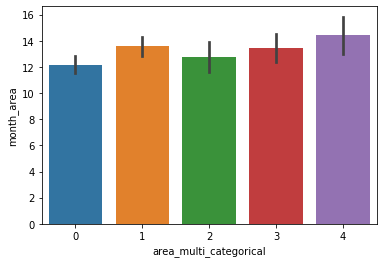

In [26]:
from numpy import mean

sns.barplot(data=data_create_features, x='area_multi_categorical', y='month_area', estimator=mean)

## Clustering

In [27]:
X = data.drop(['area_multi_categorical'], axis = 1)
y = data['area_multi_categorical']

In [28]:
X['month_area'] = X.groupby("month")["area"].transform("mean")

In [29]:
X = X.drop(['area'],axis=1)

In [30]:
features = ['DMC', 'DC', 'ISI', 'temp', 'RH', 'wind', 'location', 'month_area']

In [31]:
from sklearn.cluster import KMeans

kmeans = KMeans(n_clusters=5)
X["cluster"] = kmeans.fit_predict(X[features])
X["cluster"] = X["cluster"].astype("category")

X.head()

,X,Y,month,day,FFMC,DMC,DC,ISI,temp,RH,wind,rain,location,month_area,cluster
0,7,5,7,0,86.2,26.2,94.3,5.1,8.2,51,6.7,0.0,25,4.356667,1
1,7,4,10,5,90.6,35.4,669.1,6.7,18.0,33,0.9,0.0,24,6.638000,0
2,7,4,10,2,90.6,43.7,686.9,6.7,14.6,33,1.3,0.0,24,6.638000,0
3,8,6,7,0,91.7,33.3,77.5,9.0,8.3,97,4.0,0.2,30,4.356667,1
4,8,6,7,3,89.3,51.3,102.2,9.6,11.4,99,1.8,0.0,30,4.356667,1


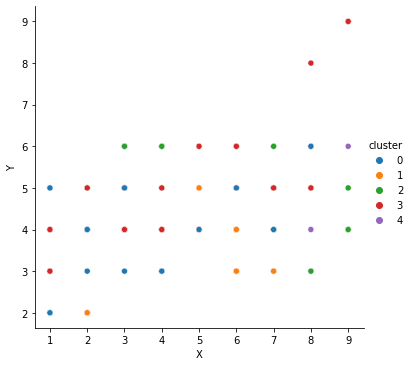

In [32]:
sns.relplot(
    x="X", y="Y", hue="cluster", data=X, height=5,
);

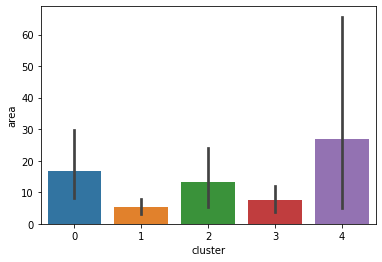

In [33]:
sns.barplot(data=X, x='cluster', y=data['area'], estimator=mean)

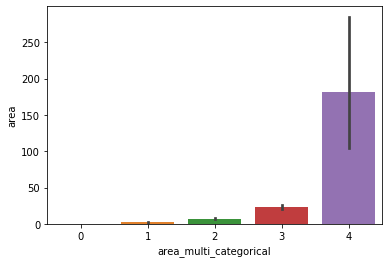

In [34]:
sns.barplot(data=data, x='area_multi_categorical', y='area', estimator=mean)

In [35]:
def remap(x):
    if x == 4:
        return 4 # Small
    elif x == 0:
        return 3 # Medium
    elif x == 2:
        return 2 # Large
    elif x == 3:
        return 1 # Very Large
    else:
        return 0 # No Fires

In [36]:
y_pred = X['cluster'].apply(remap)

In [37]:
from sklearn.metrics import classification_report

print(classification_report(y, y_pred))

              precision    recall  f1-score   support

           0       0.62      0.22      0.33       247
           1       0.33      0.37      0.35       119
           2       0.15      0.16      0.16        56
           3       0.16      0.42      0.23        71
           4       0.07      0.12      0.09        24

    accuracy                           0.27       517
   macro avg       0.26      0.26      0.23       517
weighted avg       0.41      0.27      0.29       517



In [38]:
from sklearn.metrics import confusion_matrix

pd.DataFrame(confusion_matrix(y, y_pred))

,0,1,2,3,4
0,55,58,25,85,24
1,11,44,14,45,5
2,10,12,9,19,6
3,11,17,7,30,6
4,2,3,5,11,3


## PCA

In [39]:
features = ["FFMC", "DMC", "DC", "ISI", "temp", "RH", "wind", "rain"]

X = data.copy()
y = X.pop('area_multi_categorical')
X = X.loc[:, features]

# Standardize
X_scaled = (X - X.mean(axis=0)) / X.std(axis=0)

In [40]:
X_scaled

,FFMC,DMC,DC,ISI,temp,RH,wind,rain
0,-0.805180,-1.322045,-1.828706,-0.860113,-1.840857,0.411326,1.497164,-0.073197
1,-0.008094,-1.178399,0.488418,-0.509195,-0.153130,-0.691786,-1.740070,-0.073197
2,-0.008094,-1.048806,0.560173,-0.509195,-0.738668,-0.691786,-1.516813,-0.073197
3,0.191177,-1.211188,-1.896429,-0.004751,-1.823636,3.230391,-0.009824,0.602572
4,-0.243597,-0.930142,-1.796859,0.126843,-1.289763,3.352959,-1.237741,-0.073197
...,...,...,...,...,...,...,...,...
512,-1.638496,-0.845829,0.474309,-1.561947,1.534597,-0.753070,-0.735411,-0.073197
513,-1.638496,-0.845829,0.474309,-1.561947,0.518517,1.637006,0.994835,-0.073197
514,-1.638496,-0.845829,0.474309,-1.561947,0.397965,1.575722,1.497164,-0.073197
515,0.680298,0.548471,0.269122,0.499693,1.155720,-0.140230,-0.009824,-0.073197


In [41]:
from sklearn.decomposition import PCA

# Create principal components
pca = PCA()
X_pca = pca.fit_transform(X_scaled)

# Convert to dataframe
component_names = [f"PC{i+1}" for i in range(X_pca.shape[1])]
X_pca = pd.DataFrame(X_pca, columns=component_names)

X_pca.head()

,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8
0,3.205864,-0.449746,1.191865,-0.270653,-0.277244,-0.396669,-0.200855,0.191556
1,0.191123,-0.692362,-1.605626,0.744391,0.771772,-0.283774,1.046486,0.049025
2,0.417331,-0.494474,-1.383260,0.544689,0.716483,-0.507917,1.182410,0.453021
3,2.861723,1.579701,1.397983,-0.077050,2.294466,-0.346146,-0.431576,-1.004190
4,2.485793,1.644534,0.134450,-0.304417,2.811045,0.304818,-0.699337,-1.064944


In [42]:
loadings = pd.DataFrame(
    pca.components_.T,  # transpose the matrix of loadings
    columns=component_names,  # so the columns are the principal components
    index=X.columns,  # and the rows are the original features
)
loadings

,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8
FFMC,-0.427646,-0.164512,0.262415,-0.090728,0.356059,-0.733082,-0.022399,-0.219712
DMC,-0.433508,0.445561,-0.046162,-0.161058,-0.201189,-0.053325,-0.594775,0.434048
DC,-0.433127,0.368681,-0.213008,-0.099721,-0.287602,-0.053672,0.731780,-0.007852
ISI,-0.364291,-0.101598,0.463690,-0.184787,0.450910,0.569518,0.166800,0.228742
temp,-0.487721,-0.211550,-0.147386,0.190811,-0.224830,0.347814,-0.268758,-0.644585
RH,0.229028,0.711330,0.126116,-0.195015,0.318682,0.089378,-0.086464,-0.520190
wind,0.124913,-0.045594,0.704710,-0.268516,-0.628091,-0.043547,0.013998,-0.130428
rain,-0.054359,0.274483,0.366583,0.880453,-0.010291,-0.040709,0.050144,0.088574


In [43]:
def plot_variance(pca, width=8, dpi=100):
    # Create figure
    fig, axs = plt.subplots(1, 2)
    n = pca.n_components_
    grid = np.arange(1, n + 1)
    # Explained variance
    evr = pca.explained_variance_ratio_
    axs[0].bar(grid, evr)
    axs[0].set(
        xlabel="Component", title="% Explained Variance", ylim=(0.0, 1.0)
    )
    # Cumulative Variance
    cv = np.cumsum(evr)
    axs[1].plot(np.r_[0, grid], np.r_[0, cv], "o-")
    axs[1].set(
        xlabel="Component", title="% Cumulative Variance", ylim=(0.0, 1.0)
    )
    # Set up figure
    fig.set(figwidth=8, dpi=100)
    return axs

def make_mi_scores(X, y, discrete_features):
    mi_scores = mutual_info_classif(X, y, discrete_features=discrete_features)
    mi_scores = pd.Series(mi_scores, name="MI Scores", index=X.columns)
    mi_scores = mi_scores.sort_values(ascending=False)
    return mi_scores

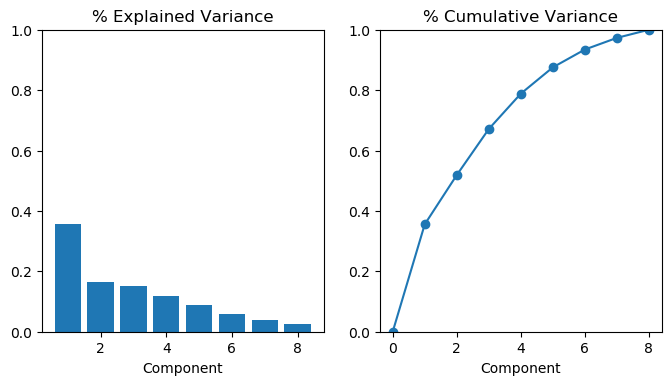

In [44]:
# Look at explained variance
plot_variance(pca);

In [45]:
mi_scores = make_mi_scores(X_pca, y, discrete_features=False)
mi_scores

PC5    0.033912
PC6    0.022674
PC4    0.022245
PC7    0.018400
PC1    0.013935
PC2    0.005912
PC3    0.000000
PC8    0.000000
Name: MI Scores, dtype: float64

# Model

In [46]:
from sklearn.model_selection import train_test_split

X = data[['DMC', 'DC', 'ISI', 'temp', 'RH', 'wind','location','month','area']]
y = data['area_multi_categorical']

In [47]:
from sklearn.model_selection import train_test_split

X_train, X_valid, y_train, y_valid = train_test_split(X, y, 
                                                      train_size=0.7, 
                                                      test_size=0.3,
                                                      random_state=42)

In [48]:
X_train["area_month"] = X_train.groupby("month")["area"].transform("mean")

# Merge the values into the validation set
X_valid = X_valid.merge(
    X_train[["month", "area_month"]].drop_duplicates(),
    on="month",
    how="left",
)

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [49]:
X_train = X_train.drop(['area','month'], axis = 1)
X_valid = X_valid.drop(['area','month'], axis = 1)

In [50]:
X_train.columns

Index(['DMC', 'DC', 'ISI', 'temp', 'RH', 'wind', 'location', 'area_month'], dtype='object')

## Base Model - SVM

In [51]:
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV

In [52]:
model = SVC()

param_grid = {
    'C': [0.001, 0.005, 0.01, 0.1, 1, 3, 5, 10, 100],
    'gamma' : [0.001, 0.005, 0.01, 0.1, 1, 3, 5, 10, 100],
}

search = GridSearchCV(model, param_grid, n_jobs=-1, cv=10)

search.fit(X_train, y_train)

GridSearchCV(cv=10, estimator=SVC(), n_jobs=-1,
             param_grid={'C': [0.001, 0.005, 0.01, 0.1, 1, 3, 5, 10, 100],
                         'gamma': [0.001, 0.005, 0.01, 0.1, 1, 3, 5, 10, 100]})

In [53]:
print(search.best_params_)

{'C': 1, 'gamma': 0.005}


In [54]:
y_pred = search.predict(X_valid)

In [55]:
from sklearn.metrics import classification_report

print(classification_report(y_valid, y_pred))

              precision    recall  f1-score   support

           0       0.55      0.94      0.69        77
           1       0.41      0.21      0.27        34
           2       1.00      0.06      0.11        17
           3       0.33      0.10      0.15        21
           4       0.00      0.00      0.00         7

    accuracy                           0.53       156
   macro avg       0.46      0.26      0.25       156
weighted avg       0.51      0.53      0.43       156



In [56]:
from sklearn.metrics import confusion_matrix

pd.DataFrame(confusion_matrix(y_valid, y_pred))

,0,1,2,3,4
0,72,3,0,1,1
1,24,7,0,3,0
2,15,1,1,0,0
3,14,5,0,2,0
4,6,1,0,0,0


---